In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from datetime import datetime
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import json
from keras.regularizers import l2
#warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
global_epoch_number = 30

## Reading data

In [3]:
# reading data
c2g_data = pd.read_csv('data/interpol/c2g_interpol_demand.csv', index_col=0)

In [4]:
c2g_data.columns

Index(['tempC', 'precipMM', 'FeelsLikeC', 'uvIndex', 'visibility',
       'windspeedMiles', 'Blizzard', 'Clear', 'Cloudy', 'Fog', 'Heavy rain',
       'Heavy rain at times', 'Heavy snow', 'Light drizzle', 'Light rain',
       'Light rain shower', 'Light sleet', 'Light sleet showers', 'Light snow',
       'Mist', 'Moderate or heavy freezing rain',
       'Moderate or heavy rain shower', 'Moderate or heavy rain with thunder',
       'Moderate or heavy sleet', 'Moderate or heavy snow showers',
       'Moderate or heavy snow with thunder', 'Moderate rain',
       'Moderate rain at times', 'Moderate snow', 'Overcast', 'Partly cloudy',
       'Patchy heavy snow', 'Patchy light drizzle', 'Patchy light rain',
       'Patchy light rain with thunder', 'Patchy light snow',
       'Patchy moderate snow', 'Patchy rain possible', 'Patchy sleet possible',
       'Patchy snow possible', 'Sunny', 'Thundery outbreaks possible',
       'Torrential rain shower', 'Monday', 'Tuesday', 'Wednesday', 'Thursday

In [5]:
c2g_data.drop(columns = ['hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23'], inplace=True)

In [6]:
unic2g_data = pd.DataFrame(c2g_data[["travels", "interpolate"]])

In [10]:
c2g_data.index = pd.to_datetime(c2g_data.index)

c2g_data = c2g_data.loc["2016-12-13 15:00:00":"2017-02-25 17:00:00"]
unic2g_data = unic2g_data.loc["2016-12-13 15:00:00":"2017-02-25 17:00:00"]

## LSTM Data Preparation

In [12]:
def sup_learning_formatter(data, past_lags, future_steps, train_split):
    X = []
    y = []
    is_y_real = []
    
    norm_data  = data.drop(columns="interpolate").values

    for n in range(len(data) - past_lags - future_steps):
        X.append(norm_data[n : n + past_lags])
        y.append(data.travels.values[n + past_lags : n + past_lags + future_steps])
        is_y_real.append(data["interpolate"].values[n + past_lags : n + past_lags + future_steps])
    return np.array(X), np.array(y), np.array(is_y_real)

In [13]:
def train_val_test_splitter(data, splits):
    print([int(len(data)*n) for n in splits])
    locs = [int(len(data)*n) for n in splits]
    return data[:locs[0]], data[locs[0]:locs[1]], data[locs[1]:], data[0].shape

In [14]:
def eval_model(y, y_hat, is_y_real=[], are_all_real=True):
    
    if not are_all_real:
        filtered_y = [[n for n, real in zip(case, real_list) if real != 1] for case, real_list in zip(y, is_y_real)]
        filtered_y_hat = [[n for n, real in zip(case, real_list) if real != 1] for case, real_list in zip(y_hat, is_y_real)]

        filtered_y = [n for n in filtered_y if n]
        filtered_y_hat = [n for n in filtered_y_hat if n]
        
    else:
        filtered_y = y
        filtered_y_hat = y_hat
    
    n = 0
    for item in filtered_y:
        n += len(item)
    
    evaluation = {}
    evaluation["RMSE"] = np.sqrt(mean_squared_error(filtered_y, filtered_y_hat))
    evaluation["MAE"] = mean_absolute_error(filtered_y, filtered_y_hat)
    evaluation["R2"] = r2_score(filtered_y, filtered_y_hat)
    diff = [[(item_y - item_y_hat)/item_y for item_y, item_y_hat in zip(line_y, line_y_hat)] for line_y, line_y_hat in zip(filtered_y, filtered_y_hat)]
    evaluation["MAPE"] = (np.sum([np.sum(np.abs(line)) for line in diff]))/n

    return evaluation

In [15]:
def run_lstm(data, past_lags, future_steps, splits, node_number, epochs=10, batch_size=64, loss='mae', layer_count=3, dropout=0.7):
    
    X, y, is_y_real = sup_learning_formatter(data, past_lags, future_steps, splits[0])
    X_train, X_val, X_test, X_shape = train_val_test_splitter(X, splits)
    y_train, y_val, y_test, y_shape = train_val_test_splitter(y, splits)
    is_y_real_train, is_y_real_val, is_y_real_test, is_y_real_shape = train_val_test_splitter(is_y_real, splits)

    train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train = train.cache().shuffle(batch_size).batch(batch_size).repeat()

    val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val = val.batch(batch_size).repeat()

    model = tf.keras.models.Sequential()

    if(layer_count == 1):
        model.add(tf.keras.layers.LSTM(node_number,
                                    input_shape=X_shape), kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))
        model.add(tf.keras.layers.Dropout(dropout))
    else:
        model.add(tf.keras.layers.LSTM(node_number, return_sequences=True,
                                    input_shape=X_shape))
        model.add(tf.keras.layers.Dropout(dropout))

        for _ in range(layer_count - 2):
            model.add(tf.keras.layers.LSTM(node_number, return_sequences=True, activation='relu', kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

        model.add(tf.keras.layers.LSTM(node_number, activation='relu', kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
        
    model.add(tf.keras.layers.Dense(12))
    
    def rmse(y_true, y_pred):
        return tf.sqrt(tf.reduce_mean((y_true - y_pred)**2))

    model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss=loss, metrics=[rmse])
    
    for x, y in val.take(1):
        print(model.predict(x).shape)
    
    history = model.fit(train, epochs=epochs, steps_per_epoch=50,
                        validation_data=val, validation_steps=50
                        )

    y_hat_val = model.predict(X_val)
    print(y_hat_val[0])
    evaluation = eval_model(y_val, y_hat_val, is_y_real_val)

    return model, history, (X_test, y_test), evaluation

In [16]:
def persistance_model(X, timesteps):
    y_hat = []
    for x in X:
        y_hat.append(np.array([x[-1][0] for _ in range(timesteps)]))

    return np.array(y_hat)

# Plot Generation

In [17]:
def performance_representation_plot(hour_skip, title, y_hat, y, title_in_plot=True, print_plot=True, upper_border=True, legend_font_size="medium",
                                    axis_value_size="medium", axis_label_size="medium"):
    
    
    data_predictions_array = []
    data_truth_array =  []
    
    for n in range(0, len(y), hour_skip):
        data_predictions_array.append(y_hat[n])
        data_truth_array.append(y[n])

    data_predictions_array = np.array(data_predictions_array).flatten()
    data_truth_array = np.array(data_truth_array).flatten()
    data_predictions_array = np.array(data_predictions_array)
    data_truth_array = np.array(data_truth_array)
    
    fig = plt.figure(figsize=(20,10))
    plt.xlabel("Horas", fontdict={"fontsize":axis_label_size})
    plt.tick_params(axis="both", labelsize=axis_value_size)
    plt.title(title + " (Hours Skiped = " + str(hour_skip) + ")") if title_in_plot else print(title + " (Hours Skiped = " + str(hour_skip) + ")")
    plt.ylabel("Viagens requisitadas por hora", fontdict={"fontsize":axis_label_size})
    plt.plot(data_truth_array, marker="o", label="Valores Reais")
    plt.plot(data_predictions_array, marker="D", label="Valores Previstos")
    if(not upper_border):
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plt.legend(fontsize=legend_font_size)
    plt.show() if print_plot else print()

In [18]:
def save_performance_to_txt(name, y_hat, y, evaluation, hour_skip=12):

    data_predictions_array = []
    data_truth_array =  []
    
    for n in range(0, len(y), hour_skip):
        data_predictions_array.append(y_hat[n])
        data_truth_array.append(y[n])

    
    data_predictions_array = np.array(data_predictions_array).flatten()
    data_truth_array = np.array(data_truth_array).flatten()
    
    data_array = np.array([data_predictions_array, data_truth_array])
    np.savetxt(f'results/LSTM_{name}_Predictions_by{str(hour_skip) + "Hrs"}.txt', data_array, delimiter=",")

    json_eval = json.dumps(evaluation, indent = 4) 
    with open(f'results/LSTM_{name}_Results.json', "w") as outfile: 
        outfile.write(json_eval)

# Training Models

In [19]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = range(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(len(history),num_out+len(history)), np.array(true_future), 'bo',
           label='True Future')
    plt.plot(np.arange(len(history),num_out+len(history)), np.array(prediction[0]), 'rX-',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [20]:
def plot_train_history(history, title, save_file=False):
    history = pd.DataFrame(history.history)

    history.plot(figsize=(8, 5))
    plt.grid(True)
    plt.savefig("plots\\" + title.replace(" ", "_") + ".png", bbox_inches='tight') if save_file else print()
    plt.show()

### Single Variable

In [21]:
print('Car2Go Model')
unic2g_model, unic2g_hist, unic2g_test, unic2g_eval = run_lstm(unic2g_data, 24, 12, (0.6, 0.8), 160,
                                                               epochs=global_epoch_number, dropout=0.3, layer_count = 3)

Car2Go Model
[1045, 1394]
[1045, 1394]
[1045, 1394]
(64, 12)
Train for 50 steps, validate for 50 steps
Epoch 1/30
50/50 [==============================] - 11s 222ms/step - loss: 138.7838 - rmse: 156.7338 - val_loss: 84.3492 - val_rmse: 94.2527
Epoch 2/30
50/50 [==============================] - 6s 125ms/step - loss: 98.9780 - rmse: 113.1373 - val_loss: 78.2873 - val_rmse: 87.4574
Epoch 3/30
50/50 [==============================] - 7s 132ms/step - loss: 79.8705 - rmse: 92.7146 - val_loss: 74.7042 - val_rmse: 82.0697
Epoch 4/30
50/50 [==============================] - 6s 124ms/step - loss: 61.8427 - rmse: 72.9318 - val_loss: 53.4284 - val_rmse: 60.7142
Epoch 5/30
50/50 [==============================] - 7s 130ms/step - loss: 51.5488 - rmse: 61.6675 - val_loss: 66.6265 - val_rmse: 80.6069
Epoch 6/30
50/50 [==============================] - 6s 122ms/step - loss: 47.9238 - rmse: 58.0945 - val_loss: 69.3012 - val_rmse: 79.1847
Epoch 7/30
50/50 [==============================] - 6s 122ms/step

In [22]:
unic2g_model.save(r'models/unic2g_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/unic2g_model\assets


In [23]:
print(unic2g_eval)
print(eval_model(unic2g_test[1], persistance_model(unic2g_test[0], 12)))

{'RMSE': 45.97922739591238, 'MAE': 33.14991622863278, 'R2': 0.721245326961772, 'MAPE': 0.3244981348054447}
{'RMSE': 143.9325154601481, 'MAE': 117.16021967526267, 'R2': -0.9867087854276555, 'MAPE': 2.6285066269214363}


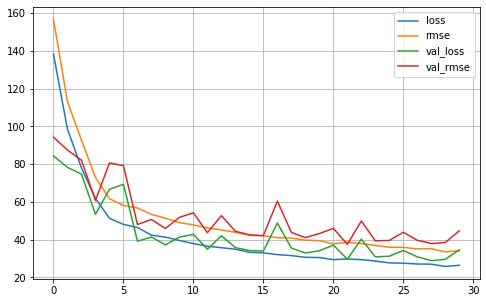

In [24]:
plot_train_history(unic2g_hist,
                   'Training and validation loss')

In [25]:
save_performance_to_txt("Car2Go_Single_Variable",
                         unic2g_model.predict(unic2g_test[0]),
                         unic2g_test[1], unic2g_eval)

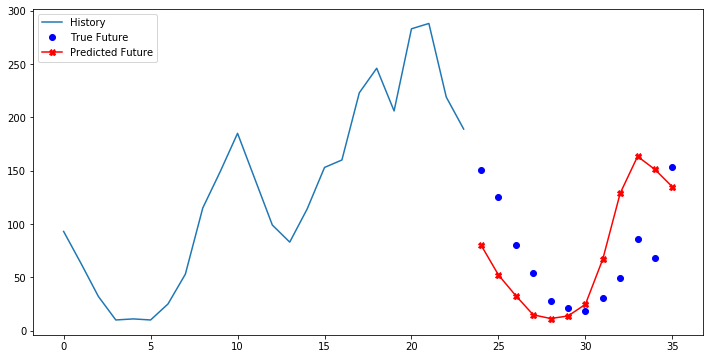

In [26]:
multi_step_plot(unic2g_test[0][10], unic2g_test[1][10], unic2g_model.predict(np.array([unic2g_test[0][10]])))

Car2Go Performance Univariável (Hours Skiped = 12)


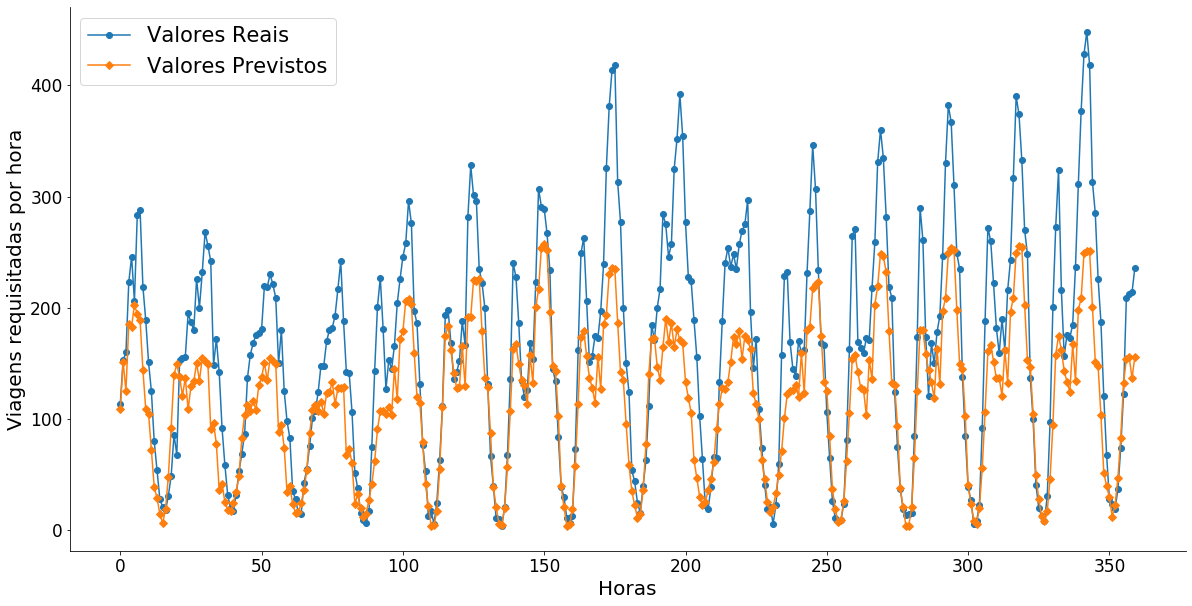

In [27]:
performance_representation_plot(12, 
                                "Car2Go Performance Univariável",
                                unic2g_model.predict(unic2g_test[0]),
                                unic2g_test[1],
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,)

### Multi Variable

In [28]:
print('Car2Go Model')
c2g_model, c2g_hist, c2g_test, c2g_eval = run_lstm(c2g_data, 24, 12, (0.6, 0.8), 220,
                                                   epochs=global_epoch_number, dropout=0.3, layer_count = 2)

Car2Go Model
[1045, 1394]
[1045, 1394]
[1045, 1394]
(64, 12)
Train for 50 steps, validate for 50 steps
Epoch 1/30
50/50 [==============================] - 10s 203ms/step - loss: 137.8910 - rmse: 154.3792 - val_loss: 63.7091 - val_rmse: 70.7662
Epoch 2/30
50/50 [==============================] - 7s 130ms/step - loss: 67.3684 - rmse: 77.9709 - val_loss: 55.8804 - val_rmse: 64.1156
Epoch 3/30
50/50 [==============================] - 7s 137ms/step - loss: 55.5991 - rmse: 65.3604 - val_loss: 47.5795 - val_rmse: 54.5658
Epoch 4/30
50/50 [==============================] - 8s 152ms/step - loss: 48.1672 - rmse: 57.7286 - val_loss: 70.8542 - val_rmse: 81.0635
Epoch 5/30
50/50 [==============================] - 7s 143ms/step - loss: 44.7167 - rmse: 54.3641 - val_loss: 42.8250 - val_rmse: 53.2921
Epoch 6/30
50/50 [==============================] - 8s 165ms/step - loss: 40.2393 - rmse: 49.5657 - val_loss: 57.2916 - val_rmse: 68.0464
Epoch 7/30
50/50 [==============================] - 8s 158ms/step 

In [29]:
c2g_model.save(r'models/c2g_model')

INFO:tensorflow:Assets written to: models/c2g_model\assets


In [30]:
print(c2g_eval)
print(eval_model(c2g_test[1], persistance_model(c2g_test[0], 12)))

{'RMSE': 35.011187730167435, 'MAE': 25.352340543829442, 'R2': 0.8383895869482142, 'MAPE': 0.3322411109084382}
{'RMSE': 188.38942310369976, 'MAE': 158.55945558739256, 'R2': -2.4121630093917843, 'MAPE': 0.9401339825445639}


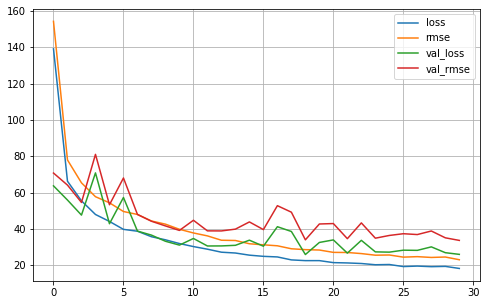

In [31]:
plot_train_history(c2g_hist, 'Training and validation loss')

In [32]:
save_performance_to_txt("Car2Go_Multivariable",
                         c2g_model.predict(c2g_test[0]),
                         c2g_test[1], c2g_eval)

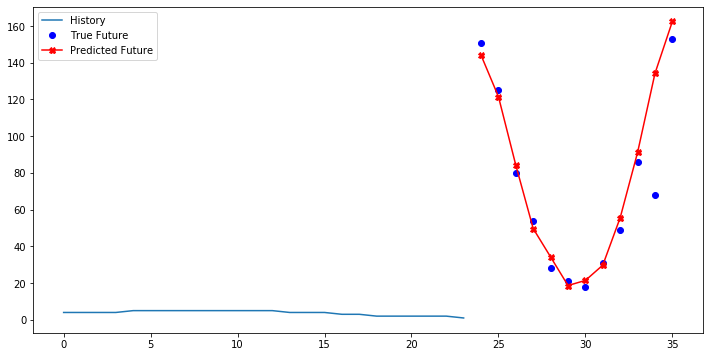

In [33]:
multi_step_plot(c2g_test[0][10], c2g_test[1][10], c2g_model.predict(np.array([c2g_test[0][10]])))

Car2Go Performance Multivariavel (Hours Skiped = 12)


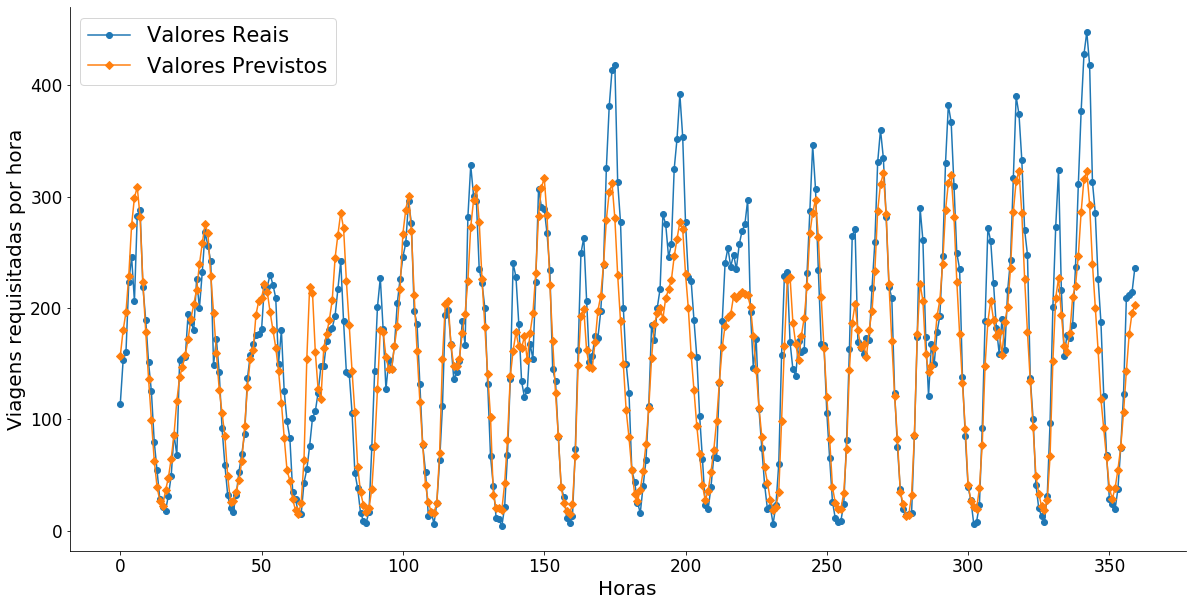

In [34]:
performance_representation_plot(12, 
                                "Car2Go Performance Multivariavel",
                                c2g_model.predict(c2g_test[0]),
                                c2g_test[1],
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,)